In [131]:
# Notebook configuration

RESULTS_DIR = "./results"

In [132]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot
import numpy as np

In [133]:
# Accumulate results jsons
jsons = []

# locate a .json files in the results data dir
for root, dir, files in os.walk(RESULTS_DIR):
    for file in files:
        
        if file.endswith(".json"):
            fpath = os.path.join(root, file)
            #if fpath.find("sv7-apu11")<0:
            #    continue
            #if fpath.find("deep-10M")<0:
            #    continue
            jsons.append(fpath)

#print(jsons)

In [ ]:
# Load into one dataframe

rows = []

for jsonfile in jsons:
    f = open(jsonfile)
    objs = json.load(f)
    f.close()

    # exclude apu12 for now
    if jsonfile.find("apu12")>=0: # something anomalous about apu12
        print("skipping", jsonfile)
        continue

    #print(jsonfile, objs[0].keys())
    for obj in objs:
        row = {}
        
        # reject criteria
        if 'benchmarkFile' not in obj.keys():
            continue
        if obj['requestTimes']['limit_10']==-1:
            continue
        # insert file name
        row['file'] = os.path.basename(jsonfile)
        row['path'] = os.path.dirname(jsonfile)
        # get gemini vs hnsw specific parms
        if row['file'].find("gemini")>=0:
            row['gemini'] = 1
            # get flat/clusters
            if row['file'].find('flat'):
                row['gem_index'] = 'flat'
            elif row['file'].find('clusters'):
                row['gem_index'] = 'clusters'
            else:
                raise Exception("Invalid gem index")
            # get size
            row["gem_size"] = obj["nBits"]
            # get cpus
            ##print(row['file'])
            row["cpus"] = int( row['file'].split(".")[-2].split("__")[-1] )
        else:
            row['gemini'] = 0
        # copy over common fields
        row['benchmarkFile'] = obj['benchmarkFile']
        row['distanceMetric'] = obj['distanceMetric']
        row['totalTested'] = obj['totalTested']
        row['recall_10'] = obj['recall']['10']['average']      
        row['latency_mean'] = obj['requestTimes']['limit_10']['latencies']['mean']
        row['latency_p90'] = obj['requestTimes']['limit_10']['latencies']['p90']
        row['latency_p95'] = obj['requestTimes']['limit_10']['latencies']['p95']
        row['latency_p99'] = obj['requestTimes']['limit_10']['latencies']['p99']     
        row['totalDatasetSize'] = obj['totalDatasetSize']
        row['importTime'] = obj['importTime']
        # copy over new common fields
        row['wallImportTime'] = obj['wallImportTime'] \
            if 'wallImportTime' in obj.keys() else np.NAN
        # copy over HNSW fields
        row['maxConnections'] = obj['maxConnections'] \
            if 'maxConnections' in obj.keys() else np.NAN
        row['ef'] = obj['ef'] if 'ef' in obj.keys() else np.NAN
        row['efConstruction'] = obj['efConstruction'] \
            if 'efConstruction' in obj.keys() else np.NAN
        # copy over APU/gemini fields
        row['trainTime'] = obj['trainTime'] \
            if 'trainTime' in obj.keys() else np.NAN
        rows.append(row)

df = pd.DataFrame(rows)
#print(df)
        

In [184]:
# Augment with various columns

regex = re.compile("deep-(\d+)[MK].hdf5")

def get_dset(row):
    matches = regex.match(row['benchmarkFile'])
    if matches:
        return 'Deep-1B'
    else:
        return "Unknown"

df['dataset'] = df.apply( lambda row: get_dset(row), axis=1 )

        

In [185]:
# Show the data

pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
#df


import time [10000, 1000000, 2000000, 5000000, 10000000, 20000000, 50000000] [0.0006481481481481482, 0.08361111111111111, 0.16833333333333333, 0.46034722222222224, 1.0059027777777778, 2.4629166666666666, 5.572222222222222]
wall import time [10000000] [5.815833333333333]


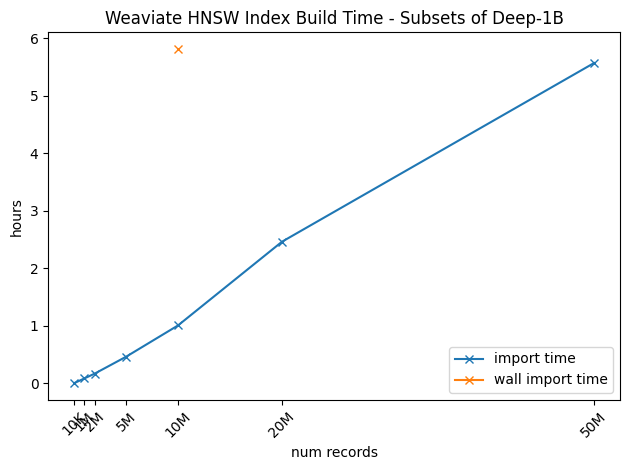

In [186]:
# Visualize import time for Deep-1B subsets for native HNSW

# compute average import time via groupby
df_import_time = df [ \
    (df['dataset']=='Deep-1B') & \
    (df['gemini']==0) ] \
    [ ['dataset', 'totalDatasetSize', 'importTime' ] ]
avg_import_time = \
    df_import_time.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        ['importTime'].mean()

# compute average wall import time via groupby
df_wall_import_time = df[ \
    (df['wallImportTime'].notnull()) & \
    (df['dataset']=='Deep-1B') & \
    (df['gemini']==0) ] \
    [ ['dataset', 'totalDatasetSize', 'wallImportTime' ] ]
##df_wall_import_time = \
#    df_wall [ ['dataset', 'totalDatasetSize', 'wallImportTime' ] ]
avg_wall_import_time = \
    df_wall_import_time.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        ['wallImportTime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_import_time.index:
    x = idx[1]
    xs.append(x)
    y = avg_import_time[idx]/(60.0*60.0)
    ys.append(y)
print("import time", xs,ys)

# get the plot points for wall import time
wxs = []
wys = []
for idx in avg_wall_import_time.index:
    x = idx[1]
    wxs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    wys.append(y)
print("wall import time", wxs,wys)

# plot the lines and label the plot
fig, ax = pyplot.subplots()
ax.plot(xs,ys, marker='x', label="import time")
ax.plot(wxs,wys, marker='x', label="wall import time")
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)
ax.set_xticklabels(['10K','1M','2M','5M','10M','20M', '50M'], rotation = 45)
ax.set_title("Weaviate HNSW Index Build Time - Subsets of Deep-1B")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_hnsw_build_time.png")

# TODO:  plot the variance at each X

import time [10000, 1000000, 2000000] [0.008556206777777792, 0.8091994621111491, 1.6500349759263195]
wall import time [10000, 1000000, 2000000] [0.008953460777777776, 1.0558740546111112, 2.1423711050925927]
train time [10000, 1000000, 2000000] [0.0013411185, 0.009009643611111113, 0.04994585055555556]


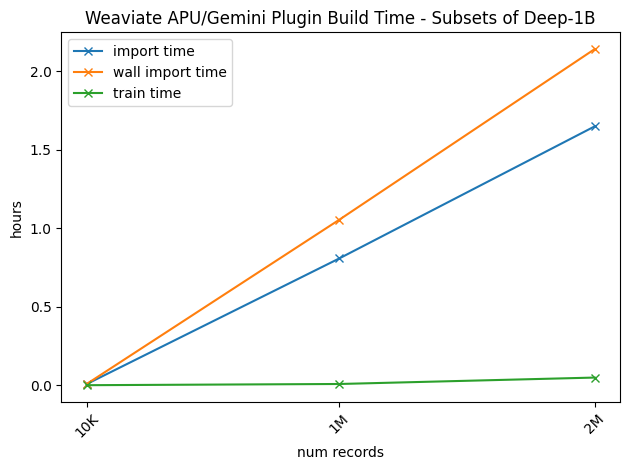

In [187]:
# Visualize import time for Deep-1B subsets for APU/Gemini Plugin

# compute average import time via groupby
df_import_time = df [ \
    (df['dataset']=='Deep-1B') & \
    (df['gemini']==1) ] \
    [ ['dataset', 'totalDatasetSize', 'importTime' ] ]
avg_import_time = \
    df_import_time.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        ['importTime'].mean()

# compute average wall import time via groupby
df_wall_import_time = df[ \
    (df['wallImportTime'].notnull()) & \
    (df['dataset']=='Deep-1B') & \
    (df['gemini']==1) ] \
    [ ['dataset', 'totalDatasetSize', 'wallImportTime' ] ]
avg_wall_import_time = \
    df_wall_import_time.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        ['wallImportTime'].mean()

# compute average train time via groupby
df_train_time = df[ \
    (df['wallImportTime'].notnull()) & \
    (df['dataset']=='Deep-1B') & \
    (df['gemini']==1) ] \
    [ ['dataset', 'totalDatasetSize', 'trainTime' ] ]
avg_train_time = \
    df_train_time.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        ['trainTime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_import_time.index:
    x = idx[1]
    xs.append(x)
    y = avg_import_time[idx]/(60.0*60.0)
    ys.append(y)
print("import time", xs,ys)

# get the plot points for wall import time
wxs = []
wys = []
for idx in avg_wall_import_time.index:
    x = idx[1]
    wxs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    wys.append(y)
print("wall import time", wxs,wys)

# get the plot points for the train time
txs = []
tys = []
for idx in avg_train_time.index:
    x = idx[1]
    txs.append(x)
    y = avg_train_time[idx]/(60.0*60.0)
    tys.append(y)
print("train time", txs,tys)

# plot the lines and label the plot
fig, ax = pyplot.subplots()
ax.plot(xs,ys, marker='x', label="import time")
ax.plot(wxs,wys, marker='x', label="wall import time")
ax.plot(txs,tys, marker='x', label="train time")
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)
ax.set_xticklabels(['10K','1M','2M'], rotation = 45)
ax.set_title("Weaviate APU/Gemini Plugin Build Time - Subsets of Deep-1B")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_gemini_build_time.png")

# TODO:  plot the variance at each X

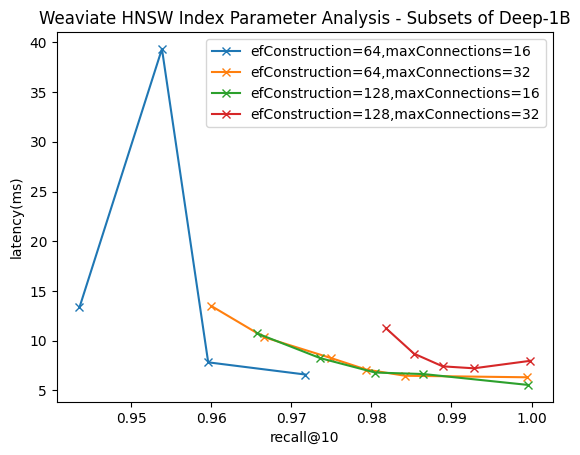

In [188]:
# Visualize the recall vs search latency for Deep-1B HNSW parameter groups

#print(df.columns)

# get Deep-1B rows
df_recall_latency = df [ df['dataset']=='Deep-1B' ] \
    [ ['dataset', 'benchmarkFile', 'totalDatasetSize', \
       'efConstruction', 'maxConnections', \
       'recall_10', 'latency_mean', 'latency_p95' ] ]

# get dataset sizes for Deep-1B so fara
dset_sizes = df[ df['dataset']=='Deep-1B' ]['totalDatasetSize'].unique()
#print(dset_sizes)

# list the different build parameter groups of interest - (efConstruction, maxConnections)
param_groups = [ (64,16), (64,32), (128,16), (128,32) ]

recall_latency_grp = df[ df['dataset']=='Deep-1B' ]\
    .groupby(['totalDatasetSize','efConstruction','maxConnections']) \
        .agg( \
        {'recall_10':['mean','min','max'],
         'latency_mean':['mean','min','max'],
         'latency_p95':['mean','min','max']})

pd.reset_option('display.width')
pd.set_option('display.width', 1000)
#print(recall_latency_grp)

#raise Exception("stop")

# extract plot points for each parameter group by dataset size
all_lines = {}
for pg in param_groups:
    # get df with those parameters
    _df = df_recall_latency[ \
        (df_recall_latency['efConstruction']==pg[0]) &
        (df_recall_latency['maxConnections']==pg[1]) ]
    #print(_df)
    # get the mean recall and latency
    recall_latency = _df.groupby(['totalDatasetSize']) \
        .mean(['recall_10','p95_latency'])
    #print(recall_latency.index)
    recall = list(recall_latency['recall_10'])
    recall = [ rc/10.0 for rc in recall ]
    latency = list(recall_latency['latency_p95'])
    latency = [ lt/1000000.0 for lt in latency ]
    #print(recall, latency)

    all_lines[ pg ] = ( recall, latency )


# plot the lines and label the plot
fig, ax = pyplot.subplots()
for ln in all_lines.keys():
    xs = all_lines[ln][0]
    ys = all_lines[ln][1]
    ax.plot(xs,ys, marker='x',label="efConstruction=%d,maxConnections=%d" % (ln[0],ln[1]))

ax.legend(loc='best')
ax.set_xlabel('recall@10')
ax.set_ylabel('latency(ms)')

ax.set_title("Weaviate HNSW Index Parameter Analysis - Subsets of Deep-1B")
fig.savefig("results/weaviate_index_parm_analysis.png")

     dataset  totalDatasetSize  recall_10  latency_mean  efConstruction                                path                                            file
112  Deep-1B             10000      9.983       2829495            64.0  ./results/h5py/sv7-apu11/gwilliams  weaviate_benchmark__deep-10K.hdf5__64__32.json
115  Deep-1B             10000     10.000       4507486            64.0  ./results/h5py/sv7-apu11/gwilliams  weaviate_benchmark__deep-10K.hdf5__64__32.json
114  Deep-1B             10000     10.000       3197210            64.0  ./results/h5py/sv7-apu11/gwilliams  weaviate_benchmark__deep-10K.hdf5__64__32.json
113  Deep-1B             10000      9.992       3466514            64.0  ./results/h5py/sv7-apu11/gwilliams  weaviate_benchmark__deep-10K.hdf5__64__32.json
61   Deep-1B           1000000      9.966       6423835            64.0  ./results/h5py/sv7-apu11/gwilliams   weaviate_benchmark__deep-1M.hdf5__64__32.json
60   Deep-1B           1000000      9.911       4640111         

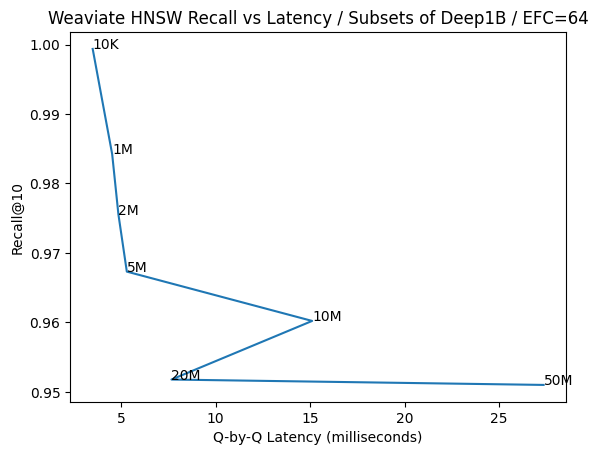

In [196]:
# plot HNSW recall vs latency

##print(df.columns)

# get only hnsw results
df_hnsw = df [ \
    (df['dataset']=='Deep-1B') & \
    (df['efConstruction']==64.0) & \
    (df['gemini']==0)  ] \
    [ ['dataset', 'totalDatasetSize', 'recall_10', 'latency_mean', 'efConstruction', 'path', 'file'] ]. \
    sort_values(['totalDatasetSize']) 
print(df_hnsw)

# compute mean of average recall_10 grouped by num records
df_hnsw_means = \
    df_hnsw.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        .mean(['recall_10','latency_mean'])
print(df_hnsw_means)

sizes = [ idx[1] for idx in list(df_hnsw_means.index) ]
sizes.sort()
print(sizes)

# get the plot points for recall vs latency
recalls = [ r*0.1 for r in list(df_hnsw_means['recall_10']) ]
latencies = [ l/1000000.0 for l in list(df_hnsw_means['latency_mean']) ]
print(recalls, latencies)

# plot the line
fig, ax = pyplot.subplots()
ax.plot(latencies,recalls)

# label the dset sizes along the line
def gethr(recs):
    if recs==10000: return "10K"
    elif recs==1000000: return "1M"
    elif recs==2000000: return "2M"
    elif recs==5000000: return "5M"
    elif recs==10000000: return "10M"
    elif recs==20000000: return "20M"
    elif recs==50000000: return "50M"
    else: return "NA"
for i,j,s in zip(latencies,recalls,sizes):
    corr = 0 #-0.05 # adds a little correction to put annotation in marker's centrum
    ax.annotate( gethr(s),  xy=(i + corr, j + corr))

ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
ax.set_title("Weaviate HNSW Recall vs Latency / Subsets of Deep1B / EFC=64")

fig.savefig("results/weaviate_hsnw_recall_vs_latency.png")

Index(['file', 'path', 'gemini', 'benchmarkFile', 'distanceMetric', 'totalTested', 'recall_10', 'latency_mean', 'latency_p90', 'latency_p95', 'latency_p99', 'totalDatasetSize', 'importTime', 'wallImportTime', 'maxConnections', 'ef', 'efConstruction', 'trainTime', 'gem_index', 'gem_size', 'cpus', 'dataset'], dtype='object')
     dataset  totalDatasetSize  recall_10  latency_mean  gem_size  cpus
62   Deep-1B             10000      9.994      11938481     256.0   1.0
34   Deep-1B           1000000      9.995      26909577     256.0   1.0
120  Deep-1B           2000000      9.987      27333086     256.0   1.0
                          recall_10  latency_mean  gem_size  cpus
dataset totalDatasetSize                                         
Deep-1B 10000                 9.994    11938481.0     256.0   1.0
        1000000               9.995    26909577.0     256.0   1.0
        2000000               9.987    27333086.0     256.0   1.0
[10000, 1000000, 2000000]
[0.9994000000000001, 0.99949999

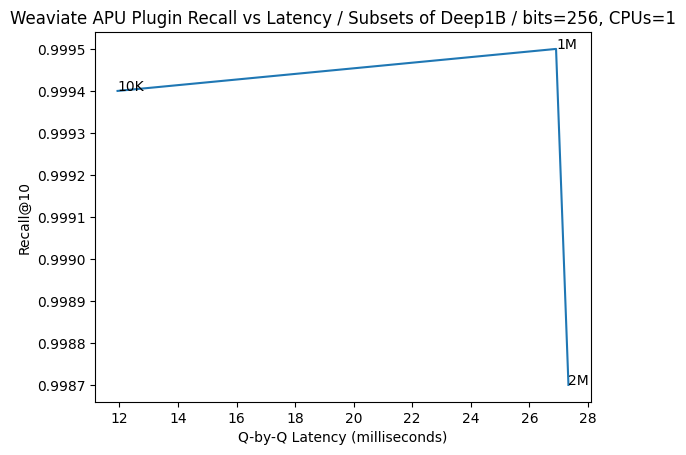

In [202]:
# plot Gemini/APU plugin recall vs latency

print(df.columns)

# get only hnsw results
df_gemini = df [ \
    (df['dataset']=='Deep-1B') & \
    (df['gemini']==1) & \
    (df['cpus']==1) & \
    (df['gem_size']==256.0)] \
    [ ['dataset', 'totalDatasetSize', 'recall_10', 'latency_mean', 'gem_size', 'cpus' ] ]. \
    sort_values(['totalDatasetSize','gem_size']) 
print(df_gemini)

# compute mean of average recall_10 grouped by num records
df_gemini_means = \
    df_gemini.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        .mean(['recall_10','latency_mean'])
print(df_gemini_means)

sizes = [ idx[1] for idx in list(df_gemini_means.index) ]
sizes.sort()
print(sizes)

# get the plot points for recall vs latency
recalls = [ r*0.1 for r in list(df_gemini_means['recall_10']) ]
latencies = [ l/1000000.0 for l in list(df_gemini_means['latency_mean']) ]
print(recalls, latencies)

# plot the line
fig, ax = pyplot.subplots()
ax.plot(latencies,recalls)

# label each point
for i,j,s in zip(latencies,recalls,sizes):
    corr = 0 #-0.05 # adds a little correction to put annotation in marker's centrum
    ax.annotate(gethr(s),  xy=(i + corr, j + corr))


ax.set_xlabel("Q-by-Q Latency (milliseconds)")
ax.set_ylabel("Recall@10")
ax.set_title("Weaviate APU Plugin Recall vs Latency / Subsets of Deep1B / bits=256, CPUs=1")

fig.savefig("results/weaviate_apu_plugin_recall_vs_latency.png")
